# Embedding Orthogonalization


In [1]:
import torch
%load_ext autoreload
%autoreload 2

import os

import numpy as np
import statsmodels.api as sm
from patsy import dmatrices

DATA_DIR = '../data'
EMBEDDING_FILE = 'chex_densenet_chex.npy'
META_FILE = 'chexpert_meta.csv'

REDUCE_DIM = True
N_COMPONENTS = 111
TARGET_DISEASE = 'Pleural Effusion'

## Load Metadata and Embedding

In [2]:
from src.utils import get_mimic_meta_data, get_chexpert_meta_data

#train_df, val_df, test_df = get_mimic_meta_data(os.path.join(DATA_DIR, META_FILE))
train_df, val_df, test_df = get_chexpert_meta_data(DATA_DIR)
print(f'DATASET SIZES: TRAIN {len(train_df)} | VAL {len(val_df)} | TEST {len(test_df)}')

emb = np.load(os.path.join(DATA_DIR, EMBEDDING_FILE))
train_emb = emb[train_df['idx']]
test_emb = emb[test_df['idx']]

DATASET SIZES: TRAIN 76205 | VAL 12673 | TEST 38240


## Apply Dimensionality Reduction

In [3]:
from src.svd import PCA

if REDUCE_DIM:
    pca = PCA()
    pca.fit(train_emb)
    print(f'Explained variance: {pca.get_total_variance(N_COMPONENTS):.3f}')

    train_emb = pca.transform(train_emb, num_components=N_COMPONENTS)
    test_emb = pca.transform(test_emb, num_components=N_COMPONENTS)
else:
    print('No dimensionality reduction was applied.')

Explained variance: 0.991


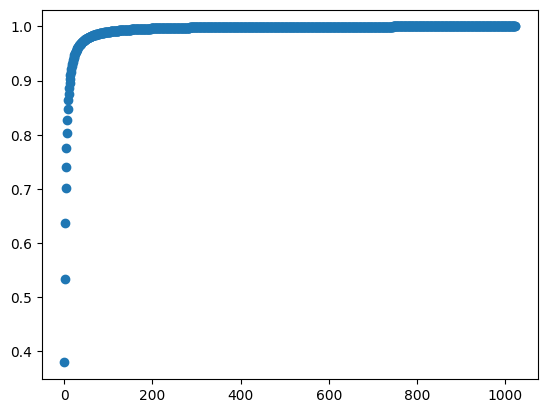

In [4]:
import matplotlib.pyplot as plt

variance_ratio = pca.explained_variance_ratio_
plt.scatter(range(len(variance_ratio)), variance_ratio)
plt.show()

## Create Response

In [5]:
# Follow U-zeros strategy for now
train_df['response'] = (train_df[TARGET_DISEASE] == 1).astype(int)
test_df['response'] = (test_df[TARGET_DISEASE] == 1).astype(int)

## Train Base Classifier

In [6]:
from src.utils import eval_predictions
from src.classifier import get_classifier

def eval_classifier(x_train, train_df, x_test, test_df):
    model = get_classifier('log_reg')
    model.fit(x_train, train_df['response'].tolist())
    
    train_df['preds'] = model.predict_proba(x_train)[:, 1]
    test_df['preds'] = model.predict_proba(x_test)[:, 1]
    
    print('-'*75 + '\nTRAINING')
    eval_predictions(train_df['response'], train_df['preds'])
    print('-'*75 + '\nTESTING')
    eval_predictions(test_df['response'], test_df['preds'])

In [7]:
eval_classifier(
    train_emb, train_df, test_emb, test_df
)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


convergence after 25 epochs took 3 seconds
---------------------------------------------------------------------------
TRAINING
METRICS:	AUC 0.8076 | ACC 0.7352 | SENS 0.6846 | SPEC 0.7699 | PREC 0.6712 | F1 0.6779
---------------------------------------------------------------------------
TESTING
METRICS:	AUC 0.8064 | ACC 0.7370 | SENS 0.6859 | SPEC 0.7718 | PREC 0.6722 | F1 0.6790


## Explain Predictions with Protected Features

In [8]:
formula = 'preds ~ 1 + age + sex + race'
mod = sm.OLS.from_formula(formula, data=train_df).fit()
print(mod.summary())
print(sm.stats.anova_lm(mod))

                            OLS Regression Results                            
Dep. Variable:                  preds   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     584.0
Date:                Mon, 31 Jul 2023   Prob (F-statistic):               0.00
Time:                        16:43:57   Log-Likelihood:                -3618.4
No. Observations:               76205   AIC:                             7247.
Df Residuals:                   76200   BIC:                             7293.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.2652      0.004     62.692

## Remove Protected Features from Result Prediction

Residuals = part of predictions that can't be explained by protected features

In [9]:
train_df['preds_adjusted'] = mod.resid

# Check: p-vals should all be one
formula = 'preds_adjusted ~ 1 + age + sex + race'
mod_check = sm.OLS.from_formula(formula, data=train_df).fit()
print(mod_check.summary())

                            OLS Regression Results                            
Dep. Variable:         preds_adjusted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                 7.063e-12
Date:                Mon, 31 Jul 2023   Prob (F-statistic):               1.00
Time:                        16:43:57   Log-Likelihood:                -3618.4
No. Observations:               76205   AIC:                             7247.
Df Residuals:                   76200   BIC:                             7293.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -1.691e-16      0.004     -4e-14

## Adjust Embedding

In [10]:
# Create the design matrix
formula = '1 ~ age + sex + race'
_, x_train = dmatrices(formula, data=train_df)
_, x_test = dmatrices(formula, data=test_df)

print(x_train.shape)

(76205, 5)


In [11]:
from src.ortho import Orthogonalizator

ortho = Orthogonalizator()
train_emb_proj = ortho.fit_transform(x_train, train_emb)
test_emb_proj = ortho.transform(x_test, test_emb)

## Check classifier performance on adjusted embedding

In [12]:
eval_classifier(
    train_emb_proj, train_df, test_emb_proj, test_df
)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


convergence after 20 epochs took 2 seconds
---------------------------------------------------------------------------
TRAINING
METRICS:	AUC 0.8012 | ACC 0.7306 | SENS 0.6690 | SPEC 0.7730 | PREC 0.6691 | F1 0.6691
---------------------------------------------------------------------------
TESTING
METRICS:	AUC 0.7995 | ACC 0.7287 | SENS 0.6775 | SPEC 0.7637 | PREC 0.6617 | F1 0.6695


In [13]:
formula = 'preds ~ 1 + age + sex + race'
mod_fixed = sm.OLS.from_formula(formula, data=train_df).fit()
print(mod_fixed.summary())
print(sm.stats.anova_lm(mod_fixed))

                            OLS Regression Results                            
Dep. Variable:                  preds   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.265
Date:                Mon, 31 Jul 2023   Prob (F-statistic):              0.281
Time:                        16:44:01   Log-Likelihood:                -3361.3
No. Observations:               76205   AIC:                             6733.
Df Residuals:                   76200   BIC:                             6779.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.4145      0.004     98.329

## Add Protected Features to classifier

In [14]:
train_mat = np.concatenate([train_emb_proj, x_train], axis=1)
test_mat = np.concatenate([test_emb_proj, x_test], axis=1)

eval_classifier(
    train_mat, train_df, test_mat, test_df
)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


convergence after 19 epochs took 3 seconds
---------------------------------------------------------------------------
TRAINING
METRICS:	AUC 0.8080 | ACC 0.7352 | SENS 0.6839 | SPEC 0.7704 | PREC 0.6715 | F1 0.6776
---------------------------------------------------------------------------
TESTING
METRICS:	AUC 0.7808 | ACC 0.7114 | SENS 0.6638 | SPEC 0.7439 | PREC 0.6388 | F1 0.6511


## Classify protected features

In [15]:
train_df['response'] = (train_df['sex'] == 'M').astype(int)
test_df['response'] = (test_df['sex'] == 'M').astype(int)

eval_classifier(
    train_emb, train_df, test_emb, test_df
)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


convergence after 31 epochs took 3 seconds
---------------------------------------------------------------------------
TRAINING
METRICS:	AUC 0.8748 | ACC 0.7986 | SENS 0.8457 | SPEC 0.7316 | PREC 0.8178 | F1 0.8315
---------------------------------------------------------------------------
TESTING
METRICS:	AUC 0.8759 | ACC 0.7980 | SENS 0.8487 | SPEC 0.7273 | PREC 0.8127 | F1 0.8303


In [16]:
eval_classifier(
    train_emb_proj, train_df, test_emb_proj, test_df
)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.31766404
Epoch 3, change: 0.11725101
Epoch 4, change: 0.07074989
Epoch 5, change: 0.04924126
Epoch 6, change: 0.02773905
Epoch 7, change: 0.02079799
Epoch 8, change: 0.01315545
Epoch 9, change: 0.00895822
Epoch 10, change: 0.00709491
Epoch 11, change: 0.00556310
Epoch 12, change: 0.00406803
Epoch 13, change: 0.00307153
Epoch 14, change: 0.00225187
Epoch 15, change: 0.00168430
Epoch 16, change: 0.00123781
Epoch 17, change: 0.00089388
Epoch 18, change: 0.00067271
Epoch 19, change: 0.00050510
Epoch 20, change: 0.00037454
Epoch 21, change: 0.00027573
Epoch 22, change: 0.00020600
Epoch 23, change: 0.00015066
Epoch 24, change: 0.00011114
Epoch 1, change: 1.00000000
Epoch 2, change: 0.24111999
Epoch 3, change: 0.08224027
Epoch 4, change: 0.04420441
Epoch 5, change: 0.02356983
Epoch 6, change: 0.01601729
Epoch 7, change: 0.01169566
Epoch 8, change: 0.00912904
Epoch 9, change: 0.00599837
Epoch 10, change: 0.00323015
Epoch 11, change: 0.00223782
Epo

/home/tobias/Projects/chexray-ortho/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [17]:
model = get_classifier('nn_nl')
model.fit(train_emb_proj, train_df['response'].tolist())

train_df['preds'] = model.predict_proba(train_emb_proj)[:, 1]
test_df['preds'] = model.predict_proba(test_emb_proj)[:, 1]

print('-'*75 + '\nTRAINING')
eval_predictions(train_df['response'], train_df['preds'])
print('-'*75 + '\nTESTING')
eval_predictions(test_df['response'], test_df['preds'])

/home/tobias/Projects/chexray-ortho/.venv/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


---------------------------------------------------------------------------
TRAINING
METRICS:	AUC 0.9989 | ACC 0.9840 | SENS 0.9914 | SPEC 0.9734 | PREC 0.9815 | F1 0.9864
---------------------------------------------------------------------------
TESTING
METRICS:	AUC 0.9994 | ACC 0.9880 | SENS 0.9949 | SPEC 0.9783 | PREC 0.9846 | F1 0.9897


## Project adjusted embedding back to original data space and classify again

In [18]:
eval_classifier(
    pca.inverse_transform(train_emb_proj), 
    train_df, 
    pca.inverse_transform(test_emb_proj),
    test_df
)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


convergence after 26 epochs took 19 seconds
---------------------------------------------------------------------------
TRAINING
METRICS:	AUC 0.5009 | ACC 0.5875 | SENS 1.0000 | SPEC 0.0000 | PREC 0.5875 | F1 0.7402
---------------------------------------------------------------------------
TESTING
METRICS:	AUC 0.4815 | ACC 0.5822 | SENS 1.0000 | SPEC 0.0000 | PREC 0.5822 | F1 0.7360
